In [1]:
from __future__ import print_function

In [2]:
%matplotlib inline
import logging
import datetime
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pylab import rcParams

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, GaussianNoise
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


Using TensorFlow backend.


In [3]:
# memoryの制限
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [4]:
#GPUを認識できてるか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10613582014036259153, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1269065318
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 224174539153257534
 physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 213450752
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12984831753745886569
 physical_device_desc: "device: 1, name: Tesla K40c, pci bus id: 0000:02:00.0, compute capability: 3.5"]

In [5]:
#Tuning
dataset = "ModelNet10"
# dataset = "ModelNet40"
cells = 32
batch_size = 128
epochs = 40
learning_rate = 0.01

In [6]:
if dataset == "ModelNet10":
    data_dir = "data10/cell" + str(cells) + "/"
    fig_dir = "fig10/cell" + str(cells) + "/"
    weights_dir = "weights10/cell" + str(cells) + "/"
    num_classes = 10
    class_name_modelnet = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [7]:
if dataset == "ModelNet40":
    data_dir = "data40/cell" + str(cells) + "/"
    fig_dir = "fig40/cell" + str(cells) + "/"
    weights_dir = "weights40/cell" + str(cells) + "/"
    num_classes = 40
    class_name_modelnet = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [8]:
train_or_test = ["train","test"]

In [9]:
if os.path.exists(weights_dir) == False:
    os.makedirs(weights_dir)
if os.path.exists(fig_dir) == False:
    os.makedirs(fig_dir)

In [10]:
# optimizer = SGD(lr=0.01, momentum=0.9, decay=0.00016667, nesterov=False)
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=0.00016667, nesterov=False)

# init model
model = Sequential()

# convolution 1
model.add(Conv3D(input_shape=(1, cells, cells, cells),
                            nb_filter=32,
                            kernel_dim1=5,
                            kernel_dim2=5,
                            kernel_dim3=5,
                            init='normal',
                            border_mode='valid',
                            subsample=(2, 2, 2),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 1
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))



#Activation ReLu
model.add(Activation(ReLU()))

# dropout 1
model.add(Dropout(p=0.4))

# convolution 2
model.add(Conv3D(nb_filter=32,
                            kernel_dim1=3,
                            kernel_dim2=3,
                            kernel_dim3=3,
                            init='normal',
                            border_mode='valid',
                            subsample=(1, 1, 1),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 2
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))

#Activation ReLu
model.add(Activation(ReLU()))

# max pool 1
model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=None,
                           border_mode='valid',
                           dim_ordering='th'))

# dropout 2
model.add(Dropout(p=0.4))

# dense 1 (fully connected layer)
model.add(Flatten())

model.add(Dense(output_dim=528, #128
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

# dropout 3
model.add(Dropout(p=0.5))

# dense 2 (fully connected layer)
model.add(Dense(output_dim=num_classes,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

#Activation Softmax
model.add(Activation("softmax"))

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(1, 32, 32..., kernel_size=(5, 5, 5), filters=32, strides=(2, 2, 2), padding="valid", data_format="channels_first", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/takitani/anaconda3/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as ReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_siz

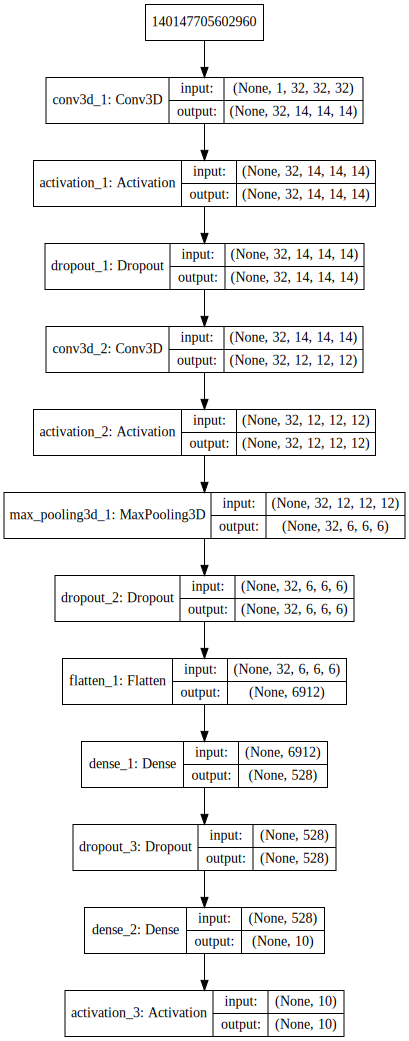

In [11]:
#可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [12]:
#サマリーの表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 14, 14, 14)    4032      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 14, 14, 14)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14, 14)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 12, 12, 12)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 12, 12, 12)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 6, 6, 6)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 6, 6, 6)       0         
__________

In [13]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model.png',show_shapes='True')

In [14]:
model

In [15]:
x_train = np.load( data_dir  + "x_train.npy")
x_test = np.load( data_dir  + "x_test.npy")
y_train = np.load( data_dir + "y_train.npy")
y_test = np.load( data_dir + "y_test.npy")

In [16]:
x_train.shape

(3991, 1, 32, 32, 32)

In [17]:
y_train.shape

(3991, 10)

In [18]:
x_test.shape

(908, 1, 32, 32, 32)

In [19]:
y_test.shape

(908, 10)

In [20]:
# es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [21]:
result = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))
#                    callbacks=[es_cb])

time_now = datetime.datetime.now()
time_now = "_{0}_{1}_{2}_{3}_{4}_{5}".format(time_now.year, time_now.month, time_now.day,
                                             time_now.hour, time_now.minute, time_now.second)
logging.info("save model weights as [weights_{0}.h5]".format(time_now))
model.save_weights(weights_dir+"weights_{0}.h5".format(time_now), False)

Train on 3991 samples, validate on 908 samples
Epoch 1/40
3991/3991 [==============================] - 5s 1ms/step - loss: 10.7216 - acc: 0.5415 - val_loss: 10.1384 - val_acc: 0.7379
Epoch 2/40
3991/3991 [==============================] - 3s 803us/step - loss: 9.7161 - acc: 0.7975 - val_loss: 9.6174 - val_acc: 0.8062
Epoch 3/40
3991/3991 [==============================] - 3s 822us/step - loss: 9.4390 - acc: 0.8504 - val_loss: 9.3906 - val_acc: 0.8491
Epoch 4/40
3991/3991 [==============================] - 3s 747us/step - loss: 9.2536 - acc: 0.8737 - val_loss: 9.2650 - val_acc: 0.8513
Epoch 5/40
3991/3991 [==============================] - 3s 818us/step - loss: 9.0804 - acc: 0.8963 - val_loss: 9.1001 - val_acc: 0.8524
Epoch 6/40
3991/3991 [==============================] - 3s 799us/step - loss: 8.9334 - acc: 0.9070 - val_loss: 8.9865 - val_acc: 0.8700
Epoch 7/40
3991/3991 [==============================] - 3s 773us/step - loss: 8.8181 - acc: 0.9113 - val_loss: 8.8961 - val_acc: 0.8392
E

In [22]:
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 6.146114519514176
Test accuracy: 0.8909691629955947


In [23]:
rcParams["figure.figsize"] = [6.4, 4.8]

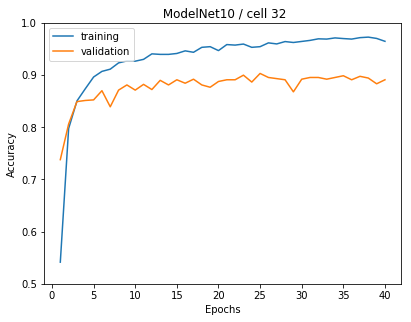

In [24]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cells))
plt.savefig(fig_dir + 'acc.svg')
plt.show()

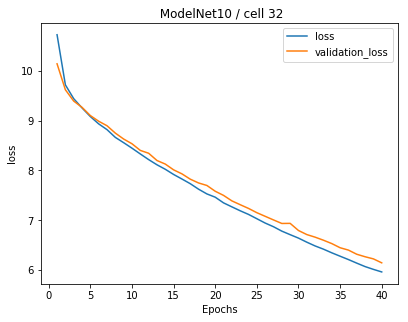

In [25]:
plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label="loss")
plt.plot(range(1, len(result.history['val_loss'])+1), result.history['val_loss'], label="validation_loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title(" {} / cell {}".format(dataset,cells))
plt.savefig(fig_dir  + 'loss.svg')
plt.show()

In [26]:
labels_pred = model.predict_classes(x_test,verbose=0)
confusion_matrix(np.argmax(y_test, axis=1), labels_pred)

array([[ 47,   0,   0,   0,   0,   3,   0,   0,   0,   0],
       [  0,  98,   0,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,  75,   8,   0,   1,   1,   1,   0,   0],
       [  0,   0,  19,  56,   9,   2,   0,   0,   0,   0],
       [  0,   0,   0,   1,  69,   0,  30,   0,   0,   0],
       [  0,   0,   0,   0,   0, 100,   0,   0,   0,   0],
       [  0,   0,   0,   2,  11,   0,  70,   0,   3,   0],
       [  0,   0,   0,   1,   0,   0,   1,  98,   0,   0],
       [  0,   0,   2,   1,   0,   0,   0,   0,  97,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  99]])

In [27]:
labels_pred

array([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 3, 6, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 7, 2, 3, 3, 2, 3, 2, 3,
       2, 3, 3, 3, 2, 3, 3, 4, 4, 2, 2, 4, 3, 3, 3, 3, 4, 3, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3,
       3, 3, 3, 4, 2, 2, 3, 3, 2, 3, 4, 4, 5, 3, 3,

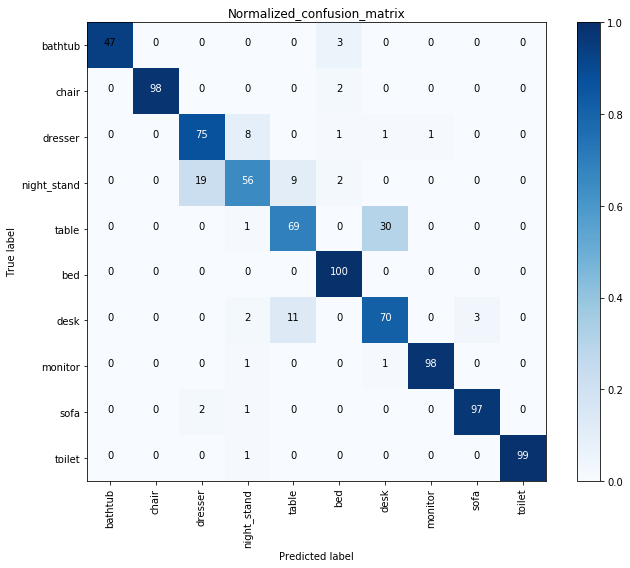

In [28]:
# グラフのサイズ
rcParams['figure.figsize'] = 10,8

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), labels_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_name_modelnet,
                      title='Normalized_confusion_matrix')
plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
plt.show()

In [29]:
np.argmax(y_test, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

# dataseto MIRO 
# CONV2DLSTM
# lamda